In [1]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import PIL
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam ,SGD
from sklearn.metrics import mean_squared_error as MSE_SKL
from sklearn.metrics import mean_absolute_error as MAE_SKL
from tensorflow.keras.metrics import mean_absolute_error as MAE_TF
from tensorflow.keras.regularizers import L2
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.models import Model
import os

In [2]:
# Check if tensorflow detectects the gpu or not
if tf.test.gpu_device_name():
    print("Gpu available: {}".format(tf.test.gpu_device_name()))
else:
    print("Tensor Flow has not detected the gpu")

Gpu available: /device:GPU:0


In [3]:
# Function to preprocess the image
def preprocess_image(image):
    # Enhance edges using adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Apply a bilateral filter to remove noise while keeping edges sharp
    filtered_image = cv2.bilateralFilter(enhanced_image, d=9, sigmaColor=75, sigmaSpace=75)
    enhanced_image = cv2.cvtColor(enhanced_image,cv2.COLOR_GRAY2RGB)
    filtered_image = cv2.cvtColor(filtered_image,cv2.COLOR_GRAY2RGB)
    return enhanced_image, filtered_image

In [4]:
test_inputImg = pd.read_csv('Data/test_data.csv', delimiter=',')
test_images = []
test_images_rgb_blured = []

test_images_hsv = []
test_images_hsv_blured = []


test_images_enhanced = []
test_images_filtered = []

test_coords = []



for row in test_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    test_x_1_coord = []
    for i in range(0,len(coords)-1,2):
        test_x_1_coord.append((coords[i]))
        test_x_1_coord.append((coords[i+1]))
    test_coords.append(np.array(test_x_1_coord))
    gray_image = cv2.imread('Data/ROI images/' + image_object[0],cv2.IMREAD_GRAYSCALE )
    enhanced_image, filtered_image = preprocess_image(gray_image)
    #gray_resized_image = cv2.resize(gray_image,(250,600))
    
    #rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    rgb_resized_image = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))

    

    test_images.append(rgb_resized_image)
    test_images_rgb_blured.append(blured_rgb_resized_image)

    test_images_enhanced.append(enhanced_image)
    test_images_filtered.append(filtered_image)

    test_images_hsv.append(hsv_resized_image)
    test_images_hsv_blured.append(blured_hsv_resized_image)

In [5]:
print("Type of test_images", type(test_images))
print("Shape of test_images ",(np.array(test_images).shape),"\n")

print("Type of test_images", type(test_images_hsv))
print("Shape of test_images ",(np.array(test_images_hsv).shape),"\n")

print("Type of test_coords", type(test_coords))
print("Shape of test_coords",(np.array(test_coords).shape))

Type of test_images <class 'list'>
Shape of test_images  (67, 600, 250, 3) 

Type of test_images <class 'list'>
Shape of test_images  (67, 600, 250, 3) 

Type of test_coords <class 'list'>
Shape of test_coords (67, 38)


In [6]:
test_images_stacked= np.stack(test_images, axis=0)
test_images_rgb_blured_stacked= np.stack(test_images_rgb_blured, axis=0)

test_images_hsv_stacked= np.stack(test_images_hsv, axis=0)
test_images_hsv_blured_stacked= np.stack(test_images_hsv_blured, axis=0)

test_images_enhanced_stacked= np.stack(test_images_enhanced, axis=0)
test_images_filtered_stacked= np.stack(test_images_filtered, axis=0)


test_labels = np.array(test_coords)

In [7]:
# Load the model from the .h5 file
InceptionResNetV2 = tf.keras.models.load_model('incep_adabtiveLR_600_enhanced.h5')


In [8]:
start_time = time.time()

prediction_IncepRes=InceptionResNetV2.predict(test_images_filtered_stacked)

end_time =  time.time()

print("prediction_time:",end_time-start_time)


3/3 [==============================] - 2s 93ms/step
prediction_time: 2.0561017990112305


In [9]:
print("Mean Absolute Error: ",MAE_SKL(test_labels, prediction_IncepRes))

Mean Absolute Error:  22.62428580656449


In [10]:
def calculate_pck(test_labels, predictions, threshold=40):
    total_points = 0
    correct_points = 0
    for label, prediction in zip(test_labels, predictions):
        for i in range(0, len(label), 2):
            if np.linalg.norm(np.array(label[i:i+2]) - np.array(prediction[i:i+2])) < threshold:
                correct_points += 1
        total_points += len(label) // 2
    pck = (correct_points / total_points) * 100
    return pck

pck = calculate_pck(test_labels, prediction_IncepRes)
print("Percentage of Correct Keypoints (PCK): ", pck, "%")


Percentage of Correct Keypoints (PCK):  63.1578947368421 %


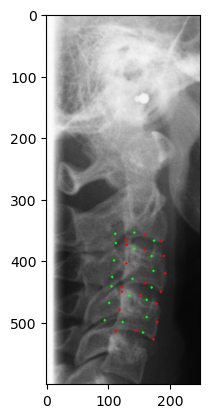

In [11]:
img_number = 15
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[img_number])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)

In [12]:
"""img_number = 45
for num in range(len(test_images_stacked)):
    img_number = num
    print(num)
    img = np.copy(test_images_stacked[img_number])
    for i in range(0,len(test_labels[img_number])-1,2):
        img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
        img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
    plt.imshow(img)
    cv2.imshow("img",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()"""

'img_number = 45\nfor num in range(len(test_images_stacked)):\n    img_number = num\n    print(num)\n    img = np.copy(test_images_stacked[img_number])\n    for i in range(0,len(test_labels[img_number])-1,2):\n        img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)\n        img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)\n    plt.imshow(img)\n    cv2.imshow("img",img)\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()'

[112.84808 356.10464 143.26567 354.7273  175.23756 367.85858 113.61281
 371.3229  143.68373 380.4854  171.90683 392.1656  110.842   399.69345
 174.84077 416.67114 107.56416 426.92188 140.24568 429.00604 171.17227
 443.3248  106.38144 441.7263  135.91388 456.40344 163.72691 463.9126
 102.05506 468.68378 163.42282 491.41437  95.85158 496.66544 124.85927
 499.74808 157.99106 516.5822 ]


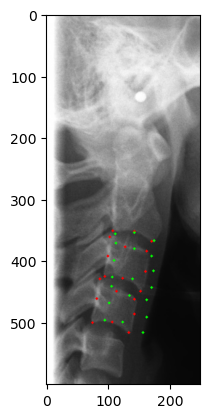

In [15]:
img_number = 25
print(prediction_IncepRes[img_number])
img = np.copy(test_images_stacked[img_number])
for i in range(0,len(test_labels[4])-1,2):
    img = cv2.circle(img, (int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (255,0,0),-1)
    img = cv2.circle(img, (int(prediction_IncepRes[img_number][i]),int(prediction_IncepRes[img_number][i+1])), 2, (0,255,0),-1)
plt.imshow(img)